In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict, OrderedDict
from tqdm import tqdm
import datetime
import os

# visualization
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# encoding
from sklearn import preprocessing, metrics

# machine learning
from lightgbm import LGBMRegressor
import joblib
import gc
import lightgbm as lgb

# regression 
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

## 1. Load Data
There are three data tables: Sales, price, and calendar.
The hierarchical data covers daily sales record for Walmat in CA, TX, WI covering three categories: hobbies, household, foods from 2011-01-29 to 2016-04-24. 
The calendar datatable summarizes the dates, day of week, month, year, and if there are events in the day or if it's a snap day.

#### Target
predict sales in the last month

In [3]:
INPUT_DIR_PATH = os.getcwd()

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + '/sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + '/calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + '/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + '/sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df

In [5]:
sell_price, calendar, sales_train, submission = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


In [6]:
sales_train.shape

(30490, 1919)

In [7]:
sales_train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [8]:
calendar.shape

(1969, 14)

In [9]:
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [10]:
sell_price.shape

(6841121, 4)

In [11]:
sell_price.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812
3     CA_1  HOBBIES_1_001     11328    8.257812
4     CA_1  HOBBIES_1_001     11329    8.257812

In [12]:
# change d_ to real date
d_cols = [c for c in sales_train.columns if 'd_' in c]
past_sales = sales_train.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'], left_index=True, 
                                                         right_index=True, validate='1:1').set_index('date').sort_index()
past_sales.head()

HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_003_CA_1_validation  HOBBIES_1_004_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_005_CA_1_validation  HOBBIES_1_006_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_007_CA_1_validation  HOBBIES_1_008_CA_1_validation  \
date                                                                       
2011-01-29                              0                             12   
2011-01-30                              0                             15   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_009_CA_1_validation  HOBBIES_1_010_CA_1_validation  ...  \
date                                                                      ...   
2011-01-29                              2                              0  ...   
2011-01-30                              0                              0  ...   
2011-01-31                              7                              1  ...   
2011-02-01                              3                              0  ...   
2011-02-02                              0                              0  ...   

            FOODS_3_818_WI_3_validation  FOODS_3_819_WI_3_validation  \
date                                                                   
2011-01-29                            0                           14   
2011-01-30                            0                           11   
2011-01-31                            0                            5   
2011-02-01                            0                            6   
2011-02-02                            0                            5   

            FOODS_3_820_WI_3_validation  FOODS_3_821_WI_3_validation  \
date                                                                   
2011-01-29                            1                            0   
2011-01-30                            1                            0   
2011-01-31                            1                            0   
2011-02-01                            1                            0   
2011-02-02                            1                            0   

            FOODS_3_822_WI_3_validation  FOODS_3_823_WI_3_validation  \
date                                                                   
2011-01-29                            4                            0   
2011-01-30                            4                            0   
2011-01-31    

## 2. EDA

#### 2.1 Total Sales over time
- Total sales gradually increased over that period
- Chrismas has 0 sales because all stores were closed

In [13]:

def plot_total(df):
    df1 = pd.DataFrame(df.sum(axis=1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df1.index, 
                             y=df1[df1.columns[0]], 
                             name="real data"))
    fig.add_trace(go.Scatter(x=df1.index, 
                             y=df1[df1.columns[0]].rolling(90).mean(), 
                             mode='lines+markers', 
                             name ="average data"))
    fig.update_layout(height=400, 
                      width=800, 
                      yaxis_title="Sales", 
                      xaxis_title="Time", 
                      title="Total sales")
    pio.renderers.default = 'iframe'
    fig.show()
plot_total(past_sales)

/home/lancelot/anaconda3/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



#### 2.2 Sales in each state/category/store over time
In different states
- Walmat in CA has the highest sales, and the sales in the middle of the year is higher than early and late of a year
- Sales in WI grow much faster than in other two states
- Sales in TX is stable over time

In different categories
- People in these three states spend most of money on foods
- Hobbies have the lowest sales amonth the three, and the record is pretty stable
- Household is in the middle

In different stores
- stores in CA have huge difference between each other: CA-3 has the highest sales, while CA-4 is the lowerst.
- stores in TX has the highest recored in the middle of 2014
- stores in WI boosted the sales and the end of 2013 and early 2016

In [14]:
cat_list = sales_train['cat_id'].unique()
store_list = sell_price['store_id'].unique()
state_list = ['_CA_', '_TX_', '_WI_']
color_p = {'HOBBIES': 'rgb(205, 92, 92)',
            'HOUSEHOLD': "rgb(69,179,157)", 
            'FOODS': 'rgb(244, 208, 63)', 
            'CA_1': 'rgb(0, 50, 130)',
            'CA_2': 'rgb(18, 82, 184)', 
            'CA_3': 'rgb(38, 103, 209)', 
            'CA_4': 'rgb(36, 120, 255)', 
            'TX_1': 'rgb(176, 15, 15)', 
            'TX_2': 'rgb(214, 21, 21)',
            'TX_3': 'rgb(255, 28, 28)',
            'WI_1': 'rgb(65, 128, 13)',
            'WI_2': "rgb(20, 163, 29)",
            'WI_3': 'rgb(43, 204, 54)',
            '_CA_': 'rgb(205, 92, 92)',
            '_TX_': "rgb(69,179,157)", 
            '_WI_': 'rgb(244, 208, 63)', 
}

In [15]:
def plot_type(type_, title):
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Rolling Average Sales vs. Time", "Sum Sales"))
    data_sum = {}
    for i, s in enumerate(type_):
        items = [c for c in past_sales.columns if s in c]
        data = past_sales[items].sum(axis=1).rolling(30).mean()
        data_sum[s] = past_sales[items].sum(axis=1).sum(axis=0)
        fig.add_trace(go.Scatter(x=past_sales.index, y=data, name=s,
                                marker_color=color_p[s]), row=1, col=1)

    fig.add_trace(go.Bar(x=list(data_sum.keys()), y=list(data_sum.values()), 
                         marker_color=[color_p[x] for x in list(data_sum.keys())], 
                         showlegend=False),row=1, col=2)
    fig.update_layout(height=400, width=1000, yaxis_title="Sales", xaxis_title="Time", title={'text':title,
                                                                                              'x':0.5})
    pio.renderers.default = 'iframe'
    fig.show()

plot_type(store_list, 'Store')

In [16]:
plot_type(cat_list, 'Category')

In [17]:
plot_type(state_list, 'State')

#### 2.3 Influences from snap and event
what is SNAP?
The United States federal government provides a nutrition assistance benefit called the Supplement Nutrition Assistance Program (SNAP). SNAP provides low income families and individuals with an Electronic Benefits Transfer debit card to purchase food products. In many states, the monetary benefits are dispersed to people across 10 days of the month and on each of these days 1/10 of the people will receive the benefit on their card.
It varies in different states, so the dataframe has to be separated based on the location

- foods sold less on snap days
- stores closed on christmas
- other events didn't obviously influence the sales
- data points for days with events are too small, so I prefer not to add it as a feature in the machine learning model

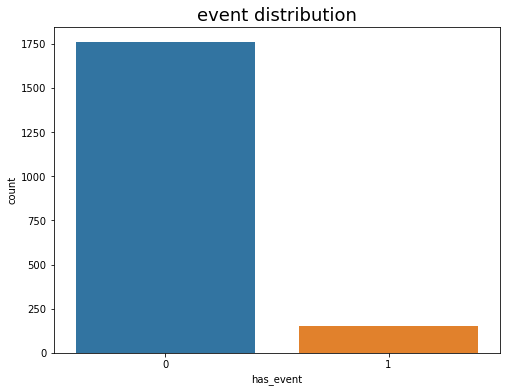

In [18]:
def plot_event_days():
    # total_sales
    df1 = past_sales.join(calendar.set_index('date')).iloc[:,:-3]
    df1['has_event'] = np.where((df1['event_name_1'].isnull()) & (df1['event_name_2'].isnull()), 0, 1)
    fig, ax = plt.subplots(figsize=(8,6))    
    g = sns.countplot(x="has_event", data=df1, ax=ax)
    g.set_ylabel('count')
    g.set_title('event distribution', fontsize=18)
plot_event_days()

In [19]:
past_sales.join(calendar.set_index('date')).columns[20000:]

Index(['FOODS_1_096_TX_3_validation', 'FOODS_1_097_TX_3_validation',
       'FOODS_1_098_TX_3_validation', 'FOODS_1_099_TX_3_validation',
       'FOODS_1_101_TX_3_validation', 'FOODS_1_102_TX_3_validation',
       'FOODS_1_103_TX_3_validation', 'FOODS_1_104_TX_3_validation',
       'FOODS_1_105_TX_3_validation', 'FOODS_1_106_TX_3_validation',
       ...
       'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object', length=10503)

In [20]:
def plot_snap_influence(state):
    # total_sales
    df1 = past_sales.join(calendar.set_index('date'))
    s_cols = [c for c in df1.columns if state in c]
    df2 = df1.loc[:,s_cols]
    total_sale = pd.DataFrame(df2.iloc[:,:-1].sum(axis=1))
    total_sale = total_sale.merge(df2.iloc[:,-1], left_index=True, right_index=True)
    total_sale_snap = total_sale.loc[total_sale.iloc[:,-1]==1]
    total_sale_nosnap = total_sale.loc[total_sale.iloc[:,-1]==0]
    # food sales
    f_cols = [c for c in df2.columns if 'FOODS' in c]
    food_sale = pd.DataFrame(df2.loc[:,f_cols].sum(axis=1))
    food_sale = food_sale.merge(df2.iloc[:,-1], left_index=True, right_index=True)
    food_sale_snap = food_sale.loc[food_sale.iloc[:,-1]==1]
    food_sale_nosnap = food_sale.loc[food_sale.iloc[:,-1]==0]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=total_sale_snap.index, y=total_sale_snap[total_sale_snap.columns[0]].rolling(7).mean(), name="toal with SNAP"))
    fig.add_trace(go.Scatter(x=total_sale_nosnap.index, y=total_sale_nosnap[total_sale_nosnap.columns[0]].rolling(7).mean(), name="total without SNAP"))
    fig.add_trace(go.Scatter(x=food_sale_snap.index, y=food_sale_snap[food_sale_snap.columns[0]].rolling(7).mean(), name="food with SNAP"))
    fig.add_trace(go.Scatter(x=food_sale_nosnap.index, y=food_sale_nosnap[food_sale_nosnap.columns[0]].rolling(7).mean(), name="food without SNAP"))
    fig.update_layout(height=400, width=800, yaxis_title="Rolling Avg. Sales", xaxis_title="Time", title="SNAP Influences on Sales in {}".format(state))
    fig.show()
    
plot_snap_influence('_CA_')

In [21]:
plot_snap_influence('_TX_')

In [22]:
plot_snap_influence('_WI_')

In [23]:
def plot_event_influence(state):
    # total
    df1 = past_sales.join(calendar.set_index('date')).iloc[:,:-3]
    df1['has_event'] = np.where((df1['event_name_1'].isnull()) & (df1['event_name_2'].isnull()), 0, 1)
    s_cols = [c for c in df1.columns if state in c]
    df2 = df1.loc[:,s_cols]
    df2['has_event'] = df1['has_event']
    total_sale = pd.DataFrame(df2.iloc[:,:-1].sum(axis=1))
    total_sale = total_sale.merge(df2.iloc[:,-1], left_index=True, right_index=True)
    total_sale_event = total_sale.loc[total_sale.iloc[:,-1]==1]
    total_sale_noevent = total_sale.loc[total_sale.iloc[:,-1]==0]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=total_sale_event.index, y=total_sale_event[total_sale_event.columns[0]], name="toal with event"))
    fig.add_trace(go.Scatter(x=total_sale_noevent.index, y=total_sale_noevent[total_sale_noevent.columns[0]], name="total without event"))
    fig.update_layout(height=400, width=800, yaxis_title="Sales", xaxis_title="Time", title="Event Influences on Sales in {}".format(state))
    fig.show()


for i in state_list:
    plot_event_influence(i)

In [24]:
def plot_event_cat(state):
    df1 = past_sales.join(calendar.set_index('date')).iloc[:,:-3]
    df1['has_event'] = np.where((df1['event_name_1'].isnull()) & (df1['event_name_2'].isnull()), 0, 1)
    s_cols = [c for c in df1.columns if state in c]
    df2 = df1.loc[:,s_cols]
    df2['has_event'] = df1['has_event']
    # total sales in each store
    total_cat = defaultdict(int)
    for cat in cat_list:
        cat_col = [c for c in df2.columns if cat in c]
        total_cat_sale = pd.DataFrame(df2.loc[:,cat_col].sum(axis=1))
        total_cat_sale['has_event'] = df2['has_event']
        total_cat [cat, 'with_event'] = total_cat_sale.loc[total_cat_sale.has_event==1].mean()[0]
        total_cat [cat, 'no_event'] = total_cat_sale.loc[total_cat_sale.has_event==0].mean()[0]       
    return total_cat      
        
plot_event_cat('_CA_')

defaultdict(int,
            {('HOBBIES', 'with_event'): 1460.5454545454545,
             ('HOBBIES', 'no_event'): 1600.3177942012508,
             ('HOUSEHOLD', 'with_event'): 3162.7662337662337,
             ('HOUSEHOLD', 'no_event'): 3383.9090392268336,
             ('FOODS', 'with_event'): 9599.616883116883,
             ('FOODS', 'no_event'): 10072.746446844798})

In [25]:
plot_event_cat('_WI_')

defaultdict(int,
            {('HOBBIES', 'with_event'): 673.8441558441558,
             ('HOBBIES', 'no_event'): 789.542922114838,
             ('HOUSEHOLD', 'with_event'): 1697.4415584415585,
             ('HOUSEHOLD', 'no_event'): 1949.7760090960774,
             ('FOODS', 'with_event'): 6340.084415584415,
             ('FOODS', 'no_event'): 6799.797043774872})

In [26]:
plot_event_cat('_TX_')

defaultdict(int,
            {('HOBBIES', 'with_event'): 781.5974025974026,
             ('HOBBIES', 'no_event'): 836.8237635019898,
             ('HOUSEHOLD', 'with_event'): 2162.525974025974,
             ('HOUSEHOLD', 'no_event'): 2283.8072768618536,
             ('FOODS', 'with_event'): 6776.727272727273,
             ('FOODS', 'no_event'): 6772.487208641273})

#### 2.4 Days/day of week heat map
- distribution in each single week is repeated, sales on weekends are higher than week days, so I decided to predict last 4 weeks of weekly sales instead of 28 days daily sales to save memory. 

In [27]:
def introduce_nulls(df):
    idx = pd.date_range(df.date.dt.date.min(), df.date.dt.date.max())
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'},inplace=True)
    return df

def calmap(cal_data, scale):
    years = [x for x in range(2011, 2017)]
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = cal_data[cal_data.index.year==year]
        #data = introduce_nulls(data)
        fig.add_trace(go.Heatmap(
            z=data.values,
            x=data.index.week,
            y=data.index.dayofweek,
            hovertext=data.index.date,
            coloraxis = "coloraxis",name=year,
        ),r,1)
        fig.update_yaxes(title_text=year,tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    #fig.update_layout(coloraxis = {'colorscale':scale})
    #fig.update_layout(template='seaborn', title=store)
    return fig

def plot_heatmap(store):
    df = past_sales.copy()
    s_cols = [c for c in df.columns if store in c]
    df = df.sum(axis=1)
    df.index = pd.to_datetime(df.index)
    #return df.index.date
    calmap(df, 'revenue').show()

plot_heatmap('CA_1')

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, 

In [28]:
plot_heatmap('CA_2')

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, 

In [29]:
plot_heatmap('CA_3')

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

<ipython-input-27-a54c043de334>:18: FutureWarning:

weekofyear and week have been deprecated, 

In [30]:
del past_sales

## 3. Merge data

In [31]:
sales_train_week = sales_train[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
# sales_train_week = sales_train_week[sales_train_week['state_id']!='TX']
sales_train_week['wm_yr_wk'] = None
sales_train_week['sales'] = 0
sales_train_week['snap_days'] = 0

for i in sales_train_week.index:
    sales_train_week.at[i, 'wm_yr_wk'] = calendar[0:-58]['wm_yr_wk'].unique()
sales_train_week = sales_train_week.explode('wm_yr_wk')

sales_train_week = pd.merge(sales_train_week, sell_price, on=['store_id','item_id','wm_yr_wk'], how='left') 

sales_train_week.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   

  state_id wm_yr_wk  sales  snap_days  sell_price  
0       CA    11101      0          0         NaN  
1       CA    11102      0          0         NaN  
2       CA    11103      0          0         NaN  
3       CA    11104      0          0         NaN  
4       CA    11105      0          0         NaN

In [32]:
calendar_snap = calendar.groupby('wm_yr_wk')[['snap_CA', 'snap_TX', 'snap_WI']].sum().to_dict('index')

cache_sales = None
cache_id = None
wk_to_days = {}
for wk in calendar[0:-58]['wm_yr_wk'].unique():
    days = calendar.loc[calendar.wm_yr_wk == wk]['d'].tolist()
    wk_to_days[wk] = [int(x[2:]) for x in days]

for i, item in tqdm(sales_train_week.iterrows()):
    id_ = item['id']
    wk = item['wm_yr_wk']
    st = 'snap_'+item['state_id']
    days = wk_to_days[wk]

    if cache_sales is None or cache_id != id_:
        cache_sales = np.array(sales_train[sales_train['id'] == id_])[0][5:]
        cache_id = id_

    s = 0
    for d in days:
        s += cache_sales[d]
    sales_train_week.at[i, 'sales'] = s
    sales_train_week.at[i, 'snap_days'] = calendar_snap[wk][st]

sales_train_week.head()

8323770it [14:11, 9777.44it/s] 


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   

  state_id wm_yr_wk  sales  snap_days  sell_price  
0       CA    11101      0          4         NaN  
1       CA    11102      0          6         NaN  
2       CA    11103      0          0         NaN  
3       CA    11104      0          0         NaN  
4       CA    11105      0          4         NaN

In [33]:
## remove old objects to release memory
del calendar_snap, cache_sales, cache_id, wk_to_days

In [34]:
sales_train_week.isna().sum()

id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
wm_yr_wk            0
sales               0
snap_days           0
sell_price    1757059
dtype: int64

In [35]:
sales_train_week = sales_train_week.fillna(0)

## 4. Feature Engineering

In [36]:
# add month and year information
calendar_new = pd.DataFrame(calendar.iloc[:,[1,4,5]].groupby(['wm_yr_wk','year'])['month'].min()).reset_index()

sales_train_week = sales_train_week.merge(calendar_new, left_on='wm_yr_wk',right_on='wm_yr_wk')

del calendar_new

In [47]:
sales_train_week.head()

item_id    dept_id   cat_id store_id  \
id                                                                          
HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

                              state_id  wm_yr_wk  sales  snap_days  \
id                                                                   
HOBBIES_1_001_CA_1_validation       CA     11101      0          4   
HOBBIES_1_002_CA_1_validation       CA     11101      0          4   
HOBBIES_1_003_CA_1_validation       CA     11101      0          4   
HOBBIES_1_004_CA_1_validation       CA     11101      0          4   
HOBBIES_1_005_CA_1_validation       CA     11101      0          4   

                               sell_price  year  ...  lag_7  lag_8  \
id                                               ...                 
HOBBIES_1_001_CA_1_validation         0.0  2011  ...    NaN    NaN   
HOBBIES_1_002_CA_1_validation         0.0  2011  ...    NaN    NaN   
HOBBIES_1_003_CA_1_validation         0.0  2011  ...    NaN    NaN   
HOBBIES_1_004_CA_1_validation         0.0  2011  ...    NaN    NaN   
HOBBIES_1_005_CA_1_validation         0.0  2011  ...    NaN    NaN   

                               rolling_monthly_mean  rolling_monthly_std  \
id                                                                         
HOBBIES_1_001_CA_1_validation                   NaN                  NaN   
HOBBIES_1_002_CA_1_validation                   NaN                  NaN   
HOBBIES_1_003_CA_1_validation                   NaN                  NaN   
HOBBIES_1_004_CA_1_validation                   NaN                  NaN   
HOBBIES_1_005_CA_1_validation                   NaN                  NaN   

                               rolling_quanter_mean  rolling_quanter_std  \
id                                                                         
HOBBIES_1_001_CA_1_validation                   NaN                  NaN   
HOBBIES_1_002_CA_1_validation                   NaN                  NaN   
HOBBIES_1_003_CA_1_validation                   NaN                  NaN   
HOBBIES_1_004_CA_1_validation                   NaN                  NaN   
HOBBIES_1_005_CA_1_validation                   NaN                  NaN   

                               expanding_monthly_mean  expanding_monthly_std  \
id                                                                             
HOBBIES_1_001_CA_1_validation                     NaN                    NaN   
HOBBIES_1_002_CA_1_validation                     NaN                    NaN   
HOBBIES_1_003_CA_1_validation                     NaN                    NaN   
HOBBIES_1_004_CA_1_validation                     NaN                    NaN   
HOBBIES_1_005_CA_1_validation                     NaN                    NaN   

                               expanding_monthly_min  expanding_monthly_max  
id                                                                           
HOBBIES_1_001_CA_1_validation                    NaN                    NaN  
HOBBIES_1_002_CA_1_validation                    NaN                    NaN  
HOBBIES_1_003_CA_1_validation                    NaN                    NaN  
HOBBIES_1_004_CA_1_validation                    NaN                    NaN  
HOBBIES_1_005_CA_1_validation                    NaN                    NaN  

[5 rows x 24 columns]

#### 4.1 Add lags
Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

In [38]:
lags = [4,5,6,7,8]
for lag in lags:
    sales_train_week['lag_'+str(lag)] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sales'].shift(lag).astype(np.float16)

In [39]:
del lags

In [40]:
sales_train_week[sales_train_week['id']=='FOODS_1_053_CA_1_validation'][['id', 'sales','lag_4','lag_5','lag_7','lag_8']].head(10)

id  sales  lag_4  lag_5  lag_7  lag_8
1663    FOODS_1_053_CA_1_validation      6    NaN    NaN    NaN    NaN
32153   FOODS_1_053_CA_1_validation      8    NaN    NaN    NaN    NaN
62643   FOODS_1_053_CA_1_validation      6    NaN    NaN    NaN    NaN
93133   FOODS_1_053_CA_1_validation      5    NaN    NaN    NaN    NaN
123623  FOODS_1_053_CA_1_validation      3    6.0    NaN    NaN    NaN
154113  FOODS_1_053_CA_1_validation      4    8.0    6.0    NaN    NaN
184603  FOODS_1_053_CA_1_validation      4    6.0    8.0    NaN    NaN
215093  FOODS_1_053_CA_1_validation      9    5.0    6.0    6.0    NaN
245583  FOODS_1_053_CA_1_validation      6    3.0    5.0    8.0    6.0
276073  FOODS_1_053_CA_1_validation      4    4.0    3.0    6.0    8.0

#### 4.2 Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps.

We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous few values, also called the rolling mean.

In [41]:
sales_train_week['rolling_monthly_mean'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.rolling(window=4).mean()).astype(np.float16)
sales_train_week['rolling_monthly_std'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.rolling(window=4).std()).astype(np.float16)
sales_train_week['rolling_quanter_mean'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.rolling(window=12).mean()).astype(np.float16)
sales_train_week['rolling_quanter_std'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.rolling(window=12).std()).astype(np.float16)

In [42]:
sales_train_week[sales_train_week['id']=='FOODS_1_053_CA_1_validation'][['id', 'sales', 'lag_4', 'rolling_monthly_mean','rolling_monthly_std','rolling_quanter_mean','rolling_quanter_std']].iloc[20:30,:]

id  sales  lag_4  rolling_monthly_mean  \
611463  FOODS_1_053_CA_1_validation      4    2.0                  3.50   
641953  FOODS_1_053_CA_1_validation      6    4.0                  3.50   
672443  FOODS_1_053_CA_1_validation      5    4.0                  3.50   
702933  FOODS_1_053_CA_1_validation      3    5.0                  3.75   
733423  FOODS_1_053_CA_1_validation      1    4.0                  4.25   
763913  FOODS_1_053_CA_1_validation      4    6.0                  4.75   
794403  FOODS_1_053_CA_1_validation      2    5.0                  5.00   
824893  FOODS_1_053_CA_1_validation      3    3.0                  4.50   
855383  FOODS_1_053_CA_1_validation      1    1.0                  3.75   
885873  FOODS_1_053_CA_1_validation      3    4.0                  3.25   

        rolling_monthly_std  rolling_quanter_mean  rolling_quanter_std  
611463             1.000000              4.082031             1.975586  
641953             1.000000              4.082031             1.975586  
672443             1.000000              4.082031             1.975586  
702933             1.258789              3.750000             1.288086  
733423             0.500000              3.583984             1.083984  
763913             0.957520              3.750000             1.288086  
794403             0.816406              3.833984             1.336914  
824893             1.291016              4.000000             1.044922  
855383             2.216797              3.833984             1.336914  
885873             1.708008              3.833984             1.336914

#### 4.3 Expanding window statistics
Windows expands, so latest data becomes more important

In [43]:
sales_train_week['expanding_monthly_mean'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)
sales_train_week['expanding_monthly_std'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.expanding(2).std()).astype(np.float16)
sales_train_week['expanding_monthly_min'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.expanding(2).min()).astype(np.float16)
sales_train_week['expanding_monthly_max'] = sales_train_week.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['lag_4'].transform(lambda x: x.expanding(2).max()).astype(np.float16)

In [44]:
sales_train_week[sales_train_week['id']=='FOODS_1_053_CA_1_validation'][['id', 'expanding_monthly_mean', 'expanding_monthly_std', 'expanding_monthly_min', 'expanding_monthly_max']].iloc[20:30,:]

id  expanding_monthly_mean  \
611463  FOODS_1_053_CA_1_validation                4.531250   
641953  FOODS_1_053_CA_1_validation                4.500000   
672443  FOODS_1_053_CA_1_validation                4.472656   
702933  FOODS_1_053_CA_1_validation                4.500000   
733423  FOODS_1_053_CA_1_validation                4.476562   
763913  FOODS_1_053_CA_1_validation                4.546875   
794403  FOODS_1_053_CA_1_validation                4.566406   
824893  FOODS_1_053_CA_1_validation                4.500000   
855383  FOODS_1_053_CA_1_validation                4.359375   
885873  FOODS_1_053_CA_1_validation                4.347656   

        expanding_monthly_std  expanding_monthly_min  expanding_monthly_max  
611463               2.003906                    1.0                    9.0  
641953               1.948242                    1.0                    9.0  
672443               1.896484                    1.0                    9.0  
702933               1.849609                    1.0                    9.0  
733423               1.805664                    1.0                    9.0  
763913               1.791992                    1.0                    9.0  
794403               1.753906                    1.0                    9.0  
824893               1.744141                    1.0                    9.0  
855383               1.845703                    1.0                    9.0  
885873               1.809570                    1.0                    9.0

In [45]:
sales_train_week['month'] = sales_train_week['month'].astype(int)
sales_train_week['year'] = sales_train_week['year'].astype(int)
sales_train_week['wm_yr_wk'] = sales_train_week['wm_yr_wk'].astype(int)
sales_train_week['sales'] = sales_train_week['sales'].astype(int)
sales_train_week['snap_days'] = sales_train_week['snap_days'].astype(int)

In [46]:
sales_train_week = sales_train_week.set_index('id')

#### 4.4 encoding

In [48]:
encoder = preprocessing.LabelEncoder()

cat = ['cat_id', 'state_id', 'item_id', 'dept_id', 'store_id']
for i in cat:
    sales_train_week[i] = encoder.fit_transform(sales_train_week[i])

In [49]:
sales_train_week = sales_train_week.dropna()

In [50]:
sales_train_week.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8018870 entries, HOBBIES_1_001_CA_1_validation to FOODS_3_827_WI_3_validation
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   item_id                 int64  
 1   dept_id                 int64  
 2   cat_id                  int64  
 3   store_id                int64  
 4   state_id                int64  
 5   wm_yr_wk                int64  
 6   sales                   int64  
 7   snap_days               int64  
 8   sell_price              float16
 9   year                    int64  
 10  month                   int64  
 11  lag_4                   float16
 12  lag_5                   float16
 13  lag_6                   float16
 14  lag_7                   float16
 15  lag_8                   float16
 16  rolling_monthly_mean    float16
 17  rolling_monthly_std     float16
 18  rolling_quanter_mean    float16
 19  rolling_quanter_std     float16
 20  expanding_monthly_mean  f

## 5. Machine Learning
I tried middle out (train and predict by category), and buttom up (train and predict by store)
by store is better because of lower RSME

In [60]:
stores = sales_train_week.store_id.unique().tolist()
len(stores)

10

#### 5.1 LGBREGRESSOR

In [63]:
stores = sales_train_week.store_id.unique().tolist()
test = pd.DataFrame(columns=['store_id',  'sales', 'pred', 'id', 'rsme']).set_index('id')
score = {}
for store in stores:
    df = sales_train_week[sales_train_week['store_id']==store]
    df = df.drop(columns = 'item_id')
    x_train = df[df['wm_yr_wk']<11609].drop(columns='sales')
    y_train = df[df['wm_yr_wk']<11609]['sales']
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train)
    scale_train = scaler.transform(x_train)
    x_val = df[df['wm_yr_wk']==11609].drop(columns='sales')
    scale_val = scaler.transform(x_val)
    y_val = df[df['wm_yr_wk']==11609]['sales']    
    x_test = df[df['wm_yr_wk']>11609].drop(columns='sales')
    y_test = df[df['wm_yr_wk']>11609]['sales']
    scale_test = scaler.transform(x_test)
    each_store = pd.concat([pd.DataFrame(y_val),pd.DataFrame(y_test)], sort=False)
    each_store['store_id'] = store
    
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )

    model.fit(scale_train, y_train, eval_set=[(scale_train,y_train),(scale_val,y_val)], eval_metric='rmse', verbose=20, early_stopping_rounds=400)
    y_pred_val = model.predict(scale_val)
    y_pred = model.predict(scale_test)
    y = np.concatenate((y_pred_val, y_pred))
    
    y_pred = model.predict(scale_test)
    each_store['rsme'] = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    each_store['pred'] = y
    test = test.append(each_store)

Training until validation scores don't improve for 400 rounds
[20]	training's rmse: 18.8173	training's l2: 354.093	valid_1's rmse: 15.9304	valid_1's l2: 253.777
[40]	training's rmse: 15.5089	training's l2: 240.527	valid_1's rmse: 12.8226	valid_1's l2: 164.418
[60]	training's rmse: 13.7025	training's l2: 187.757	valid_1's rmse: 11.0482	valid_1's l2: 122.062
[80]	training's rmse: 12.7413	training's l2: 162.34	valid_1's rmse: 10.0169	valid_1's l2: 100.338
[100]	training's rmse: 12.2353	training's l2: 149.702	valid_1's rmse: 9.43334	valid_1's l2: 88.9879
[120]	training's rmse: 11.9596	training's l2: 143.033	valid_1's rmse: 9.10193	valid_1's l2: 82.845
[140]	training's rmse: 11.8021	training's l2: 139.29	valid_1's rmse: 8.97974	valid_1's l2: 80.6357
[160]	training's rmse: 11.7007	training's l2: 136.907	valid_1's rmse: 8.90595	valid_1's l2: 79.316
[180]	training's rmse: 11.6369	training's l2: 135.418	valid_1's rmse: 8.85731	valid_1's l2: 78.452
[200]	training's rmse: 11.5822	training's l2: 1

[200]	training's rmse: 18.7083	training's l2: 350	valid_1's rmse: 11.4637	valid_1's l2: 131.416
[220]	training's rmse: 18.6289	training's l2: 347.037	valid_1's rmse: 11.4573	valid_1's l2: 131.269
[240]	training's rmse: 18.5414	training's l2: 343.784	valid_1's rmse: 11.4352	valid_1's l2: 130.763
[260]	training's rmse: 18.4681	training's l2: 341.069	valid_1's rmse: 11.4456	valid_1's l2: 131.003
[280]	training's rmse: 18.4061	training's l2: 338.784	valid_1's rmse: 11.4768	valid_1's l2: 131.716
[300]	training's rmse: 18.3576	training's l2: 337.003	valid_1's rmse: 11.5099	valid_1's l2: 132.478
[320]	training's rmse: 18.3183	training's l2: 335.561	valid_1's rmse: 11.4992	valid_1's l2: 132.231
[340]	training's rmse: 18.2646	training's l2: 333.597	valid_1's rmse: 11.5004	valid_1's l2: 132.259
[360]	training's rmse: 18.2017	training's l2: 331.302	valid_1's rmse: 11.4675	valid_1's l2: 131.504
[380]	training's rmse: 18.105	training's l2: 327.79	valid_1's rmse: 11.5542	valid_1's l2: 133.499
[400]	

[540]	training's rmse: 9.059	training's l2: 82.0655	valid_1's rmse: 9.31214	valid_1's l2: 86.716
[560]	training's rmse: 9.0507	training's l2: 81.9151	valid_1's rmse: 9.31355	valid_1's l2: 86.7423
[580]	training's rmse: 9.04155	training's l2: 81.7497	valid_1's rmse: 9.30763	valid_1's l2: 86.6319
[600]	training's rmse: 9.03329	training's l2: 81.6004	valid_1's rmse: 9.31769	valid_1's l2: 86.8193
[620]	training's rmse: 9.02066	training's l2: 81.3722	valid_1's rmse: 9.31228	valid_1's l2: 86.7186
[640]	training's rmse: 9.01211	training's l2: 81.2182	valid_1's rmse: 9.30591	valid_1's l2: 86.5999
Early stopping, best iteration is:
[248]	training's rmse: 9.23866	training's l2: 85.3528	valid_1's rmse: 9.24327	valid_1's l2: 85.438
Training until validation scores don't improve for 400 rounds
[20]	training's rmse: 20.6575	training's l2: 426.733	valid_1's rmse: 16.3518	valid_1's l2: 267.382
[40]	training's rmse: 16.4093	training's l2: 269.265	valid_1's rmse: 12.161	valid_1's l2: 147.89
[60]	trainin

[20]	training's rmse: 10.8266	training's l2: 117.215	valid_1's rmse: 10.4662	valid_1's l2: 109.542
[40]	training's rmse: 8.94482	training's l2: 80.0099	valid_1's rmse: 8.35222	valid_1's l2: 69.7596
[60]	training's rmse: 7.91664	training's l2: 62.6732	valid_1's rmse: 7.20055	valid_1's l2: 51.8479
[80]	training's rmse: 7.37285	training's l2: 54.3589	valid_1's rmse: 6.60754	valid_1's l2: 43.6596
[100]	training's rmse: 7.09114	training's l2: 50.2843	valid_1's rmse: 6.30857	valid_1's l2: 39.7981
[120]	training's rmse: 6.93127	training's l2: 48.0425	valid_1's rmse: 6.17253	valid_1's l2: 38.1001
[140]	training's rmse: 6.83489	training's l2: 46.7157	valid_1's rmse: 6.11522	valid_1's l2: 37.3959
[160]	training's rmse: 6.77095	training's l2: 45.8458	valid_1's rmse: 6.08787	valid_1's l2: 37.0621
[180]	training's rmse: 6.72707	training's l2: 45.2535	valid_1's rmse: 6.06895	valid_1's l2: 36.8321
[200]	training's rmse: 6.69315	training's l2: 44.7983	valid_1's rmse: 6.05843	valid_1's l2: 36.7046
[220

[660]	training's rmse: 11.4006	training's l2: 129.973	valid_1's rmse: 10.7284	valid_1's l2: 115.1
[680]	training's rmse: 11.3842	training's l2: 129.599	valid_1's rmse: 10.7311	valid_1's l2: 115.156
[700]	training's rmse: 11.371	training's l2: 129.299	valid_1's rmse: 10.7291	valid_1's l2: 115.115
[720]	training's rmse: 11.3582	training's l2: 129.009	valid_1's rmse: 10.7242	valid_1's l2: 115.007
Early stopping, best iteration is:
[322]	training's rmse: 11.6783	training's l2: 136.382	valid_1's rmse: 10.6095	valid_1's l2: 112.561
Training until validation scores don't improve for 400 rounds
[20]	training's rmse: 19.1895	training's l2: 368.236	valid_1's rmse: 16.8136	valid_1's l2: 282.697
[40]	training's rmse: 15.742	training's l2: 247.811	valid_1's rmse: 12.9458	valid_1's l2: 167.594
[60]	training's rmse: 13.8464	training's l2: 191.723	valid_1's rmse: 10.6568	valid_1's l2: 113.568
[80]	training's rmse: 12.8377	training's l2: 164.807	valid_1's rmse: 9.41737	valid_1's l2: 88.6869
[100]	train

In [68]:
test

store_id  sales       pred      rsme
id                                                                
HOBBIES_1_001_CA_1_validation        0      3   6.300784  8.014342
HOBBIES_1_002_CA_1_validation        0      3   1.894831  8.014342
HOBBIES_1_003_CA_1_validation        0      1   2.292493  8.014342
HOBBIES_1_004_CA_1_validation        0     15  11.586683  8.014342
HOBBIES_1_005_CA_1_validation        0      9   6.715158  8.014342
...                                ...    ...        ...       ...
FOODS_3_823_WI_3_validation          9      1   2.631307  8.567903
FOODS_3_824_WI_3_validation          9      0   1.183223  8.567903
FOODS_3_825_WI_3_validation          9      4   6.551158  8.567903
FOODS_3_826_WI_3_validation          9      5   6.643094  8.567903
FOODS_3_827_WI_3_validation          9      0  11.755328  8.567903

[121960 rows x 4 columns]

In [66]:
test['sales'] = test['sales'].astype(int)
test1 = test.groupby('store_id')[['sales','pred']].sum().reset_index()

In [67]:
traces = []
trace1 = go.Bar(x = test1.index.values, y = test1.sales, name = 'real')
trace2 = go.Bar(x = test1.index.values, y = test1.pred, name = 'predict')
traces.append(trace1)
traces.append(trace2)

layout = go.Layout(
    barmode = 'group',
    font=dict(size=10), xaxis=dict(title='Store'),
    yaxis=dict(title='Total sales in each store')
)

fig = go.Figure(data = traces, layout = layout)
fig.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 2001, dtick = 1))
fig.show()


In [167]:
test.rsme.unique()

array([ 7.93920951,  8.79270478,  4.7474234 ,  6.35188166, 14.73280594,
        8.36678937])

In [264]:
test["diff"] = abs(test['pred'] - test['sales'])
test.sort_values(by='diff', ascending=False).head(10)

store_id  sales        pred       rsme        diff
id                                                                            
FOODS_2_360_WI_2_validation        5    690  312.032736  14.251076  377.967264
FOODS_2_360_WI_2_validation        5    604  258.981569  14.251076  345.018431
FOODS_3_090_CA_3_validation        2    703  992.469563  12.963546  289.469563
FOODS_3_811_WI_2_validation        5    423  167.936468  14.251076  255.063532
FOODS_3_120_CA_3_validation        2    417  185.875176  12.963546  231.124824
FOODS_3_635_CA_3_validation        2      0  225.694445  12.963546  225.694445
FOODS_3_007_WI_2_validation        5    354  138.028298  14.251076  215.971702
FOODS_3_635_CA_3_validation        2      0  214.163453  12.963546  214.163453
FOODS_3_635_CA_3_validation        2      0  212.343668  12.963546  212.343668
FOODS_3_090_CA_3_validation        2    782  992.469563  12.963546  210.469563

''

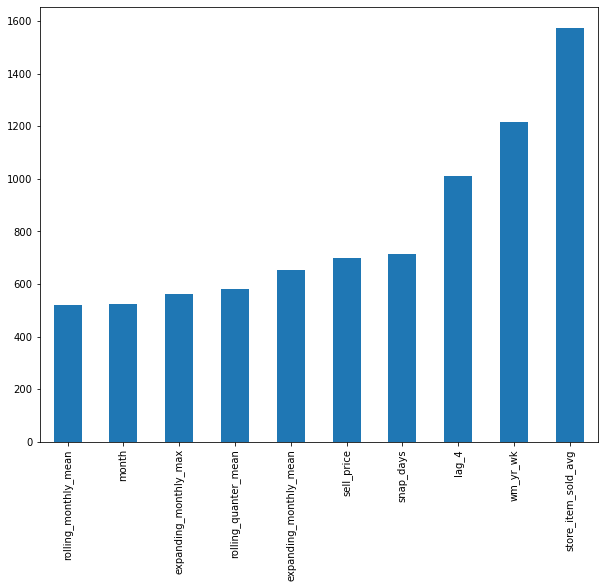

In [263]:
plt.figure(figsize=(10,8))
pd.Series(model.feature_importances_, x_train.columns).sort_values().tail(10).plot(kind='bar')
;

In [1]:
del each_store, test, x_train, y_train, x_val, y_val

NameError: name 'each_store' is not defined

In [28]:
cats = sales_train_week.cat_id.unique().tolist()
test = pd.DataFrame(columns=['cat_id',  'sales', 'pred', 'id', 'rsme']).set_index('id')
score = {}
for cat in cats:
    df = sales_train_week[sales_train_week['cat_id']==cat]
    df = df.drop(columns = 'item_id')
    x_train = df[df['wm_yr_wk']<11609].drop(columns='sales')
    y_train = df[df['wm_yr_wk']<11609]['sales']
    x_val = df[df['wm_yr_wk']==11609].drop(columns='sales')
    y_val = df[df['wm_yr_wk']==11609]['sales']    
    x_test = df[df['wm_yr_wk']>11609].drop(columns='sales')
    y_test = df[df['wm_yr_wk']>11609]['sales']
    each_cat = pd.concat([pd.DataFrame(y_val),pd.DataFrame(y_test)], sort=False)
    each_cat['cat_id'] = cat
    
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )

    model.fit(x_train, y_train, eval_set=[(x_train,y_train),(x_val,y_val)], eval_metric='rmse', verbose=20, early_stopping_rounds=400)
    y_pred_val = model.predict(x_val)
    y_pred = model.predict(x_test)
    y = np.concatenate((y_pred_val, y_pred))
    
    y_pred = model.predict(x_test)
    each_cat['rsme'] = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    each_cat['pred'] = y
    test = test.append(each_cat)

Training until validation scores don't improve for 400 rounds
[20]	training's rmse: 7.93905	training's l2: 63.0286	valid_1's rmse: 7.29594	valid_1's l2: 53.2308
[40]	training's rmse: 6.59682	training's l2: 43.518	valid_1's rmse: 5.98759	valid_1's l2: 35.8512
[60]	training's rmse: 5.87672	training's l2: 34.5358	valid_1's rmse: 5.32775	valid_1's l2: 28.3849
[80]	training's rmse: 5.5002	training's l2: 30.2522	valid_1's rmse: 5.03304	valid_1's l2: 25.3315
[100]	training's rmse: 5.29972	training's l2: 28.087	valid_1's rmse: 4.92042	valid_1's l2: 24.2106
[120]	training's rmse: 5.18722	training's l2: 26.9073	valid_1's rmse: 4.88775	valid_1's l2: 23.8901
[140]	training's rmse: 5.11399	training's l2: 26.1529	valid_1's rmse: 4.88522	valid_1's l2: 23.8653
[160]	training's rmse: 5.06779	training's l2: 25.6825	valid_1's rmse: 4.90036	valid_1's l2: 24.0136
[180]	training's rmse: 5.02554	training's l2: 25.256	valid_1's rmse: 4.91579	valid_1's l2: 24.165
[200]	training's rmse: 4.99712	training's l2: 2

[60]	training's rmse: 17.9097	training's l2: 320.759	valid_1's rmse: 14.6533	valid_1's l2: 214.72
[80]	training's rmse: 16.6757	training's l2: 278.079	valid_1's rmse: 13.314	valid_1's l2: 177.263
[100]	training's rmse: 16.0158	training's l2: 256.506	valid_1's rmse: 12.6022	valid_1's l2: 158.815
[120]	training's rmse: 15.6358	training's l2: 244.479	valid_1's rmse: 12.189	valid_1's l2: 148.572
[140]	training's rmse: 15.3893	training's l2: 236.83	valid_1's rmse: 11.9776	valid_1's l2: 143.463
[160]	training's rmse: 15.2088	training's l2: 231.308	valid_1's rmse: 11.7982	valid_1's l2: 139.197
[180]	training's rmse: 15.0774	training's l2: 227.328	valid_1's rmse: 11.6732	valid_1's l2: 136.264
[200]	training's rmse: 14.9655	training's l2: 223.967	valid_1's rmse: 11.6066	valid_1's l2: 134.713
[220]	training's rmse: 14.8548	training's l2: 220.667	valid_1's rmse: 11.5841	valid_1's l2: 134.191
[240]	training's rmse: 14.7664	training's l2: 218.046	valid_1's rmse: 11.5627	valid_1's l2: 133.696
[260]	

In [29]:
test.rsme.unique()

array([ 4.64649602,  5.74511925, 13.18361143])

In [ ]:
test['sales'] = test['sales'].astype(int)
test1 = test.groupby('cat_id')[['sales','pred']].sum().reset_index()

In [33]:
traces = []
trace1 = go.Bar(x = test1.index.values, y = test1.sales, name = 'real')
trace2 = go.Bar(x = test1.index.values, y = test1.pred, name = 'predict')
traces.append(trace1)
traces.append(trace2)

layout = go.Layout(
    barmode = 'group',
    font=dict(size=10), xaxis=dict(title='Store'),
    yaxis=dict(title='Total sales in each store')
)

fig = go.Figure(data = traces, layout = layout)
fig.update_layout(xaxis = dict(tickmode = 'linear', tick0 = 2001, dtick = 1))
fig.show()

In [38]:
test["diff"] = abs(test['pred'] - test['sales'])
test.sort_values(by='diff', ascending=False).head(10)

cat_id  sales        pred       rsme        diff
id                                                                          
FOODS_2_360_WI_2_validation      0    690  246.640932  13.183611  443.359068
FOODS_2_360_WI_2_validation      0    604  236.395548  13.183611  367.604452
FOODS_3_090_CA_3_validation      0    910  606.248965  13.183611  303.751035
FOODS_3_007_WI_2_validation      0    354   70.557677  13.183611  283.442323
FOODS_3_811_WI_2_validation      0    423  162.924965  13.183611  260.075035
FOODS_3_635_CA_3_validation      0      0  245.252474  13.183611  245.252474
FOODS_3_120_CA_3_validation      0    565  323.574105  13.183611  241.425895
FOODS_3_808_CA_3_validation      0      4  237.786959  13.183611  233.786959
FOODS_3_635_CA_3_validation      0      0  229.496870  13.183611  229.496870
FOODS_3_007_WI_2_validation      0    294   72.712938  13.183611  221.287062

''

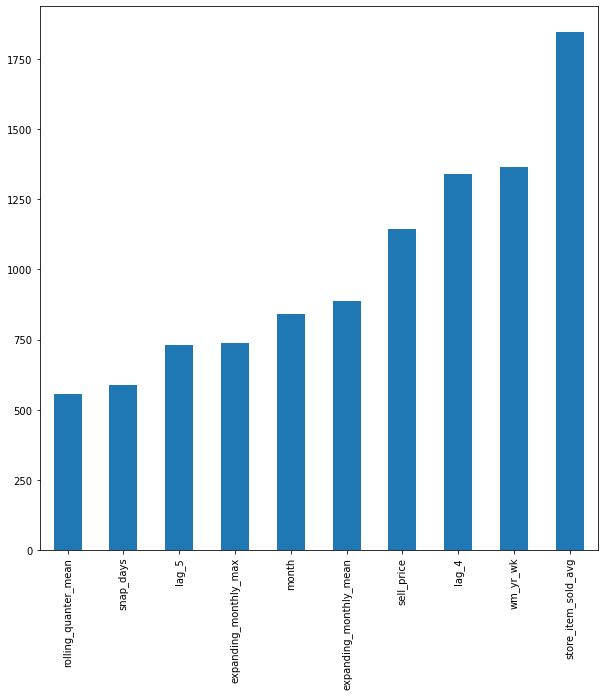

In [34]:
plt.figure(figsize=(10,10))
pd.Series(model.feature_importances_, x_train.columns).sort_values().tail(10).plot(kind='bar')
;

In [41]:
del sales_train_week, test, x_train, y_train, x_test, y_test, x_val, y_val

## ARMA

In [43]:
df = past_sales.iloc[:,[3,15000, 25000]].reset_index()

In [46]:
df['date'] = pd.to_datetime(df['date'])

In [47]:
df = df.set_index('date')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1913 entries, 2011-01-29 to 2016-04-24
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   HOBBIES_1_004_CA_1_validation    1913 non-null   int64
 1   FOODS_3_580_TX_1_validation      1913 non-null   int64
 2   HOUSEHOLD_1_046_WI_2_validation  1913 non-null   int64
dtypes: int64(3)
memory usage: 59.8 KB


<ipython-input-583-1810a05ac776>:7: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



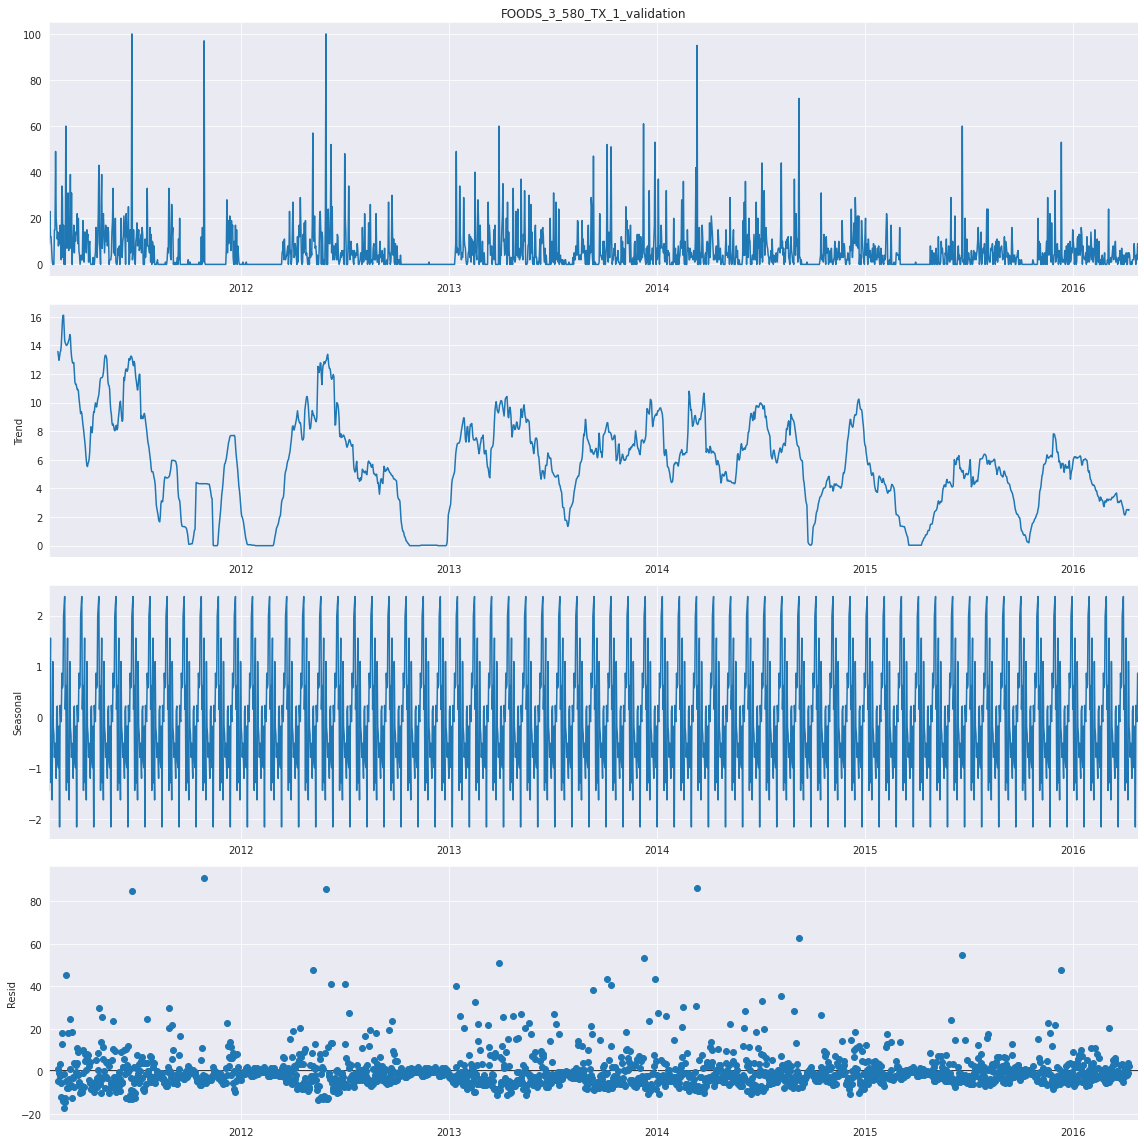

In [583]:
import statsmodels.api as sm
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 16))

res = sm.tsa.seasonal_decompose(df['FOODS_3_580_TX_1_validation'],
                                freq=30,model="additive")
fig = res.plot()

In [50]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

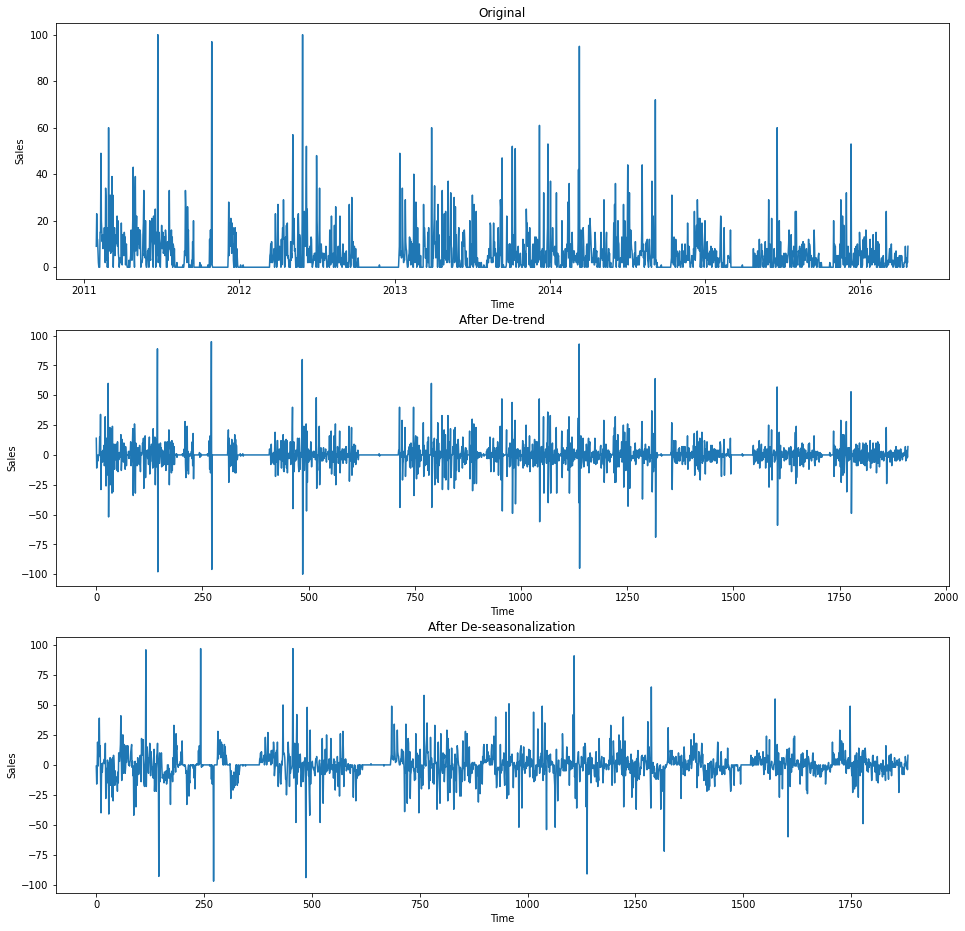

In [53]:
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(df['FOODS_3_580_TX_1_validation'])
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(df['FOODS_3_580_TX_1_validation'])
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(df['FOODS_3_580_TX_1_validation'],30)     
plt.plot(new_ts)
plt.plot()

In [54]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -1.148830e+01
p-value                        4.805002e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.874000e+03
Critical Value (1%)           -3.433844e+00
Critical Value (5%)           -2.863084e+00
Critical Value (10%)          -2.567592e+00
dtype: float64


In [55]:
test_stationarity(df['FOODS_3_580_TX_1_validation'])

Results of Dickey-Fuller Test:
Test Statistic                -9.128999e+00
p-value                        3.058103e-15
#Lags Used                     9.000000e+00
Number of Observations Used    1.903000e+03
Critical Value (1%)           -3.433791e+00
Critical Value (5%)           -2.863060e+00
Critical Value (10%)          -2.567579e+00
dtype: float64


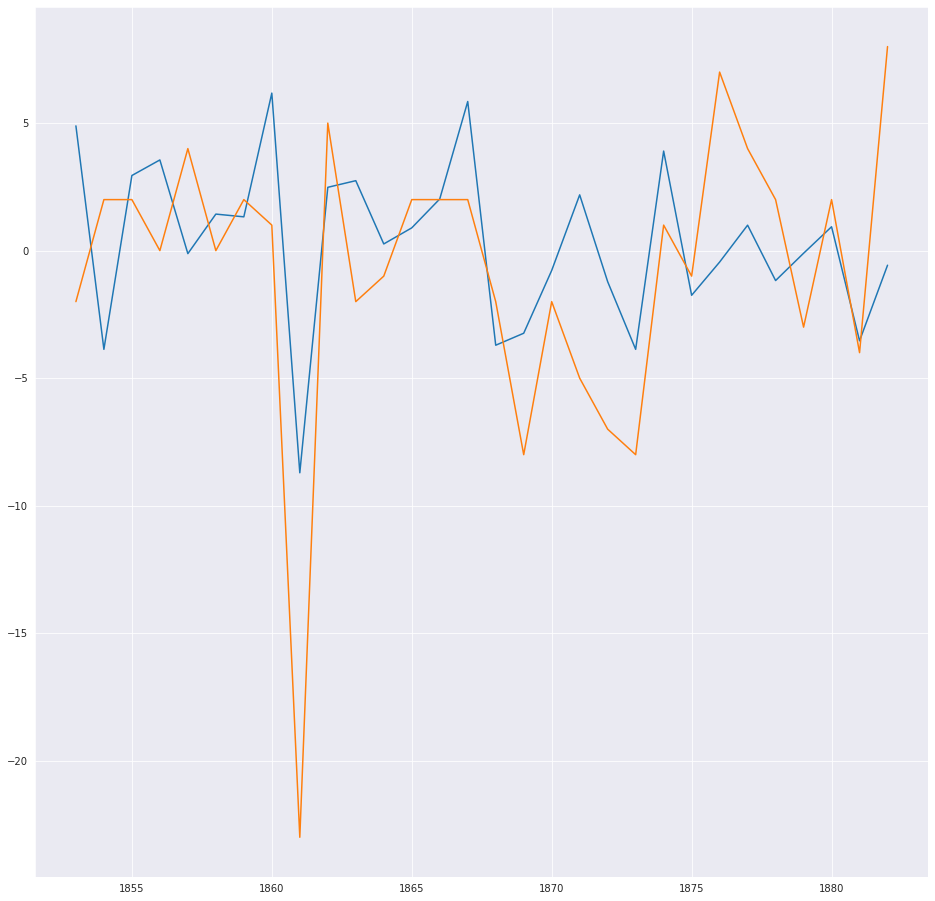

In [638]:
from statsmodels.tsa.arima.model import ARIMA
predictions = []
fit = ARIMA(new_ts[:-30], order=(30,0,3)).fit()
predictions.append(fit.forecast(30))
# error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])
plt.plot(pd.DataFrame(predictions).T)
plt.plot(np.arange(1853,1883), new_ts[-30:])

In [640]:
predictions = pd.DataFrame(predictions).T
# predictions['value'] = (df[df.columns[-59:-29]].values)[1]

In [598]:
new_ts[1822:1853]

1822     0
1823   -10
1824     4
1825    -4
1826    -8
1827    -1
1828    -2
1829    -2
1830   -13
1831    16
1832    -2
1833    -5
1834     0
1835    -1
1836    -4
1837   -12
1838     6
1839     8
1840     2
1841    -5
1842     3
1843     9
1844    -9
1845     3
1846     2
1847    -2
1848     1
1849     0
1850    -2
1851     6
1852     1
dtype: int64

In [646]:
a = df[['FOODS_3_580_TX_1_validation']][-60:-30].reset_index()
b = predictions.reset_index().drop(columns='index')
a['diff']=b[0]
a['pred']=a['FOODS_3_580_TX_1_validation']+a['diff']
a['test']=df['FOODS_3_580_TX_1_validation'][-30:].values

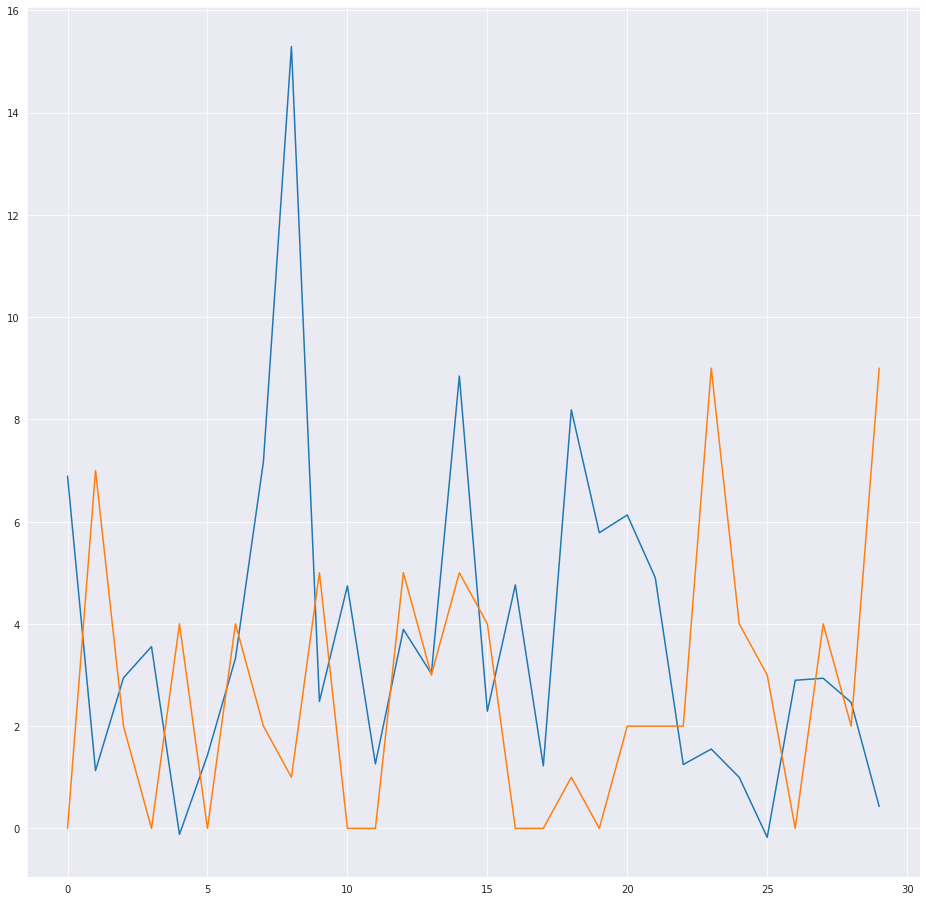

In [650]:
plt.plot(a.index, a.pred)
plt.plot(a.index, a.test)

In [614]:
calendar[calendar['date']=='2016-02-25']

date  wm_yr_wk   weekday  wday  month  year       d event_name_1  \
1853  2016-02-25     11604  Thursday     6      2  2016  d_1854          NaN   

     event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
1853          NaN          NaN          NaN        0        0        0

In [607]:
new_ts[1822:1853]

1822     0
1823   -10
1824     4
1825    -4
1826    -8
1827    -1
1828    -2
1829    -2
1830   -13
1831    16
1832    -2
1833    -5
1834     0
1835    -1
1836    -4
1837   -12
1838     6
1839     8
1840     2
1841    -5
1842     3
1843     9
1844    -9
1845     3
1846     2
1847    -2
1848     1
1849     0
1850    -2
1851     6
1852     1
dtype: int64

In [ ]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [416]:
df[df.columns[-30:]].values

array([[6, 6, 0, 0, 0, 0, 3, 1, 2, 1, 3, 1, 0, 2, 5, 4, 2, 0, 3, 0, 1, 0,
        5, 4, 1, 0, 1, 3, 7, 2],
       [0, 7, 2, 0, 4, 0, 4, 2, 1, 5, 0, 0, 5, 3, 5, 4, 0, 0, 1, 0, 2, 2,
        2, 9, 4, 3, 0, 4, 2, 9],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0]])